**Intro_to_Modeling**

In [2]:
# @title Install and import feedback gadget

!pip3 install vibecheck datatops --quiet

from vibecheck import DatatopsContentReviewContainer
def content_review(notebook_section: str):
    return DatatopsContentReviewContainer(
        "",  # No text prompt
        notebook_section,
        {
            "url": "https://pmyvdlilci.execute-api.us-east-1.amazonaws.com/klab",
            "name": "neuromatch_cn",
            "user_key": "y1x3mpx5",
        },
    ).render()


feedback_prefix = "W1D1_T1"

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# @title Figure Settings
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

import ipywidgets as widgets  # interactive display
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

In [5]:
# @title Plotting functions

def plot_isis(single_neuron_isis):
  plt.hist(single_neuron_isis, bins=50, histtype="stepfilled")
  plt.axvline(single_neuron_isis.mean(), color="orange", label="Mean ISI")
  plt.xlabel("ISI duration (s)")
  plt.ylabel("Number of spikes")
  plt.legend()
  


In [6]:
#@title Data retrieval
#@markdown This cell downloads the example dataset that we will use in this tutorial.
import io
import requests
r = requests.get('https://osf.io/sy5xt/download')
if r.status_code != 200:
  print('Failed to download data')
else:
  spike_times = np.load(io.BytesIO(r.content), allow_pickle=True)['spike_times']

In [7]:
type(spike_times)

numpy.ndarray

In [8]:
spike_times.shape

(734,)

In [12]:
idx = 321
print(
  type(spike_times[idx]),
  spike_times[idx].shape,
  #sep="\n",
)

# Print the shape of spike_times
print("Shape of spike_times:", spike_times.shape)

# Print the shapes of the sub-arrays
for idx in range(len(spike_times)):
    print(f"Shape of spike_times[{idx}]:", spike_times[idx].shape)

<class 'numpy.ndarray'> (9723,)
Shape of spike_times: (734,)
Shape of spike_times[0]: (826,)
Shape of spike_times[1]: (2818,)
Shape of spike_times[2]: (3953,)
Shape of spike_times[3]: (646,)
Shape of spike_times[4]: (1115,)
Shape of spike_times[5]: (457,)
Shape of spike_times[6]: (10305,)
Shape of spike_times[7]: (3849,)
Shape of spike_times[8]: (1225,)
Shape of spike_times[9]: (2487,)
Shape of spike_times[10]: (625,)
Shape of spike_times[11]: (1722,)
Shape of spike_times[12]: (4647,)
Shape of spike_times[13]: (12935,)
Shape of spike_times[14]: (7954,)
Shape of spike_times[15]: (3231,)
Shape of spike_times[16]: (726,)
Shape of spike_times[17]: (8610,)
Shape of spike_times[18]: (348,)
Shape of spike_times[19]: (3534,)
Shape of spike_times[20]: (1128,)
Shape of spike_times[21]: (378,)
Shape of spike_times[22]: (3097,)
Shape of spike_times[23]: (3345,)
Shape of spike_times[24]: (1285,)
Shape of spike_times[25]: (1774,)
Shape of spike_times[26]: (286,)
Shape of spike_times[27]: (5355,)
Sha

**This means that there are 733 neurons in this NeuroPixel data, each having a subarray with different size**

In [9]:
i_neurons = [0, 321]
i_print = slice(0, 5)

for i in i_neurons:
  print(
    "Neuron {}:".format(i),
    spike_times[i].dtype,
    spike_times[i][i_print],
    "\n",
    sep="\n"
  )

Neuron 0:
float32
[ 0.8149   14.822467 24.9646   25.1436   38.8709  ]


Neuron 321:
float32
[1.0698667 1.1536334 1.2403667 1.7072    1.799    ]




In [11]:
n_neurons = len(spike_times)
total_spikes_per_neuron = [len(spike_times_i) for spike_times_i in spike_times]

print(f"Number of neurons: {n_neurons}")
print(f"Number of spikes for first five neurons: {total_spikes_per_neuron[:5]}")

Number of neurons: 734
Number of spikes for first five neurons: [826, 2818, 3953, 646, 1115]


**Analyzing the data, plotting its histogram, and calculating the mean**

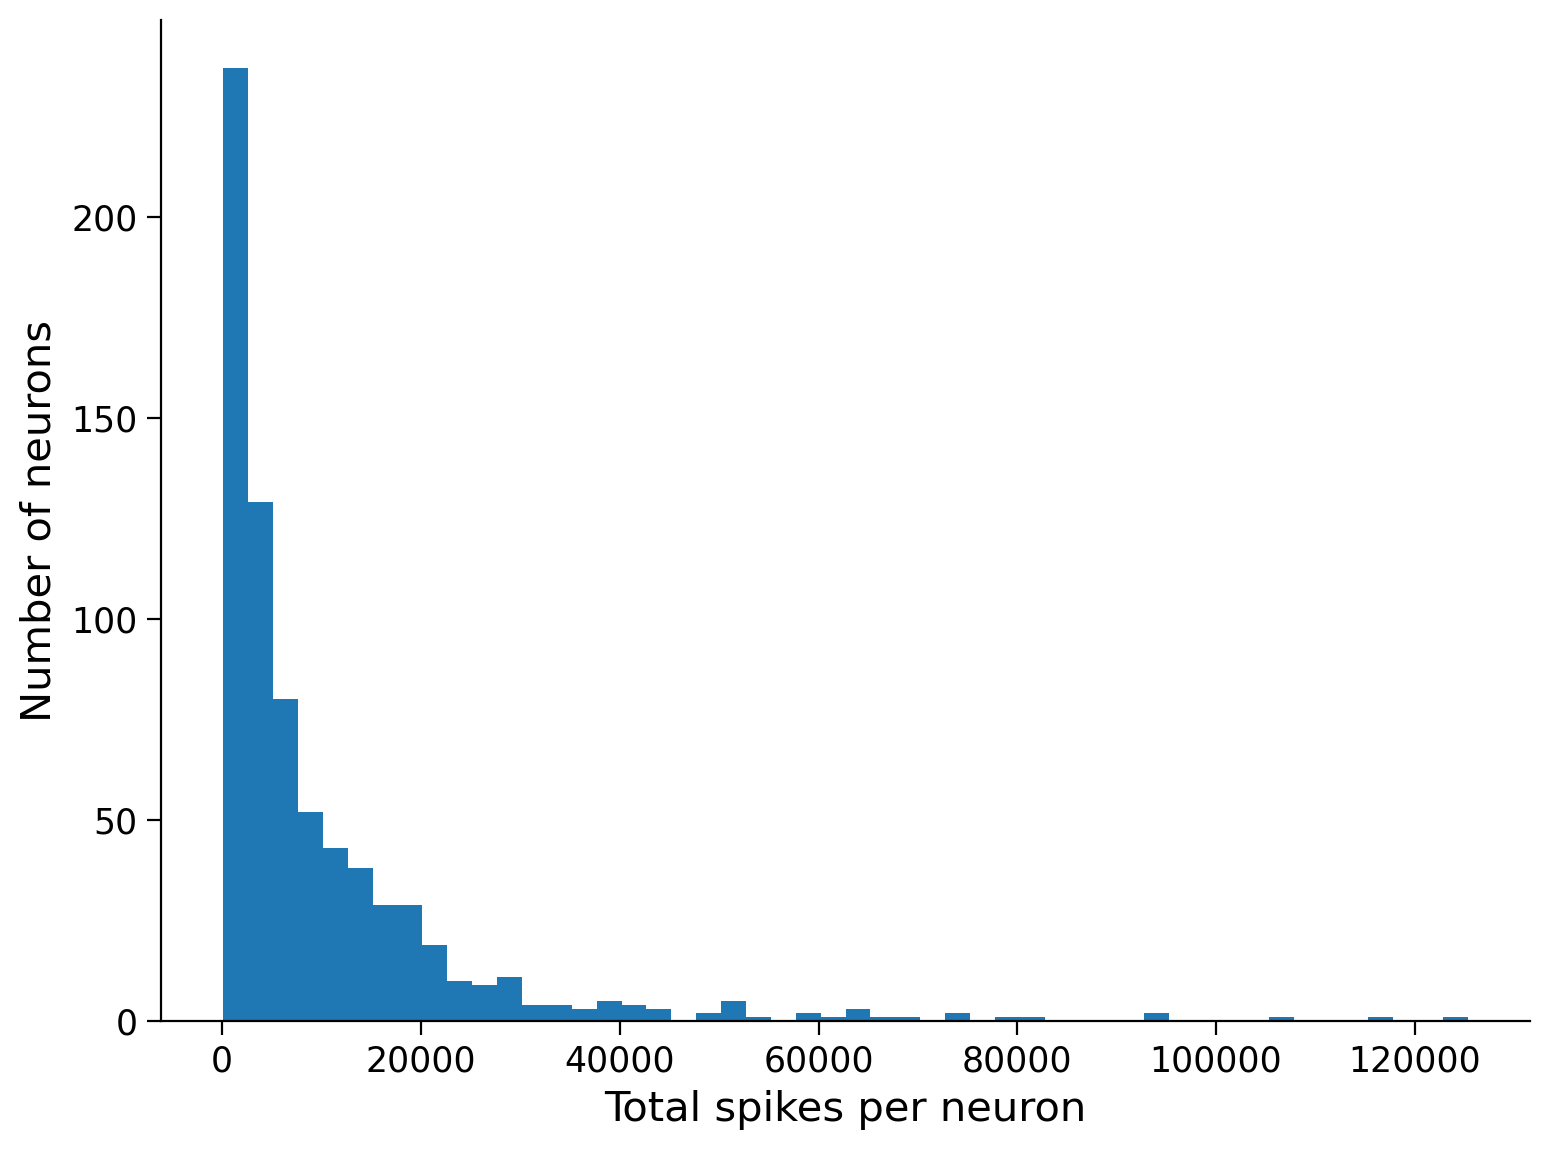

In [12]:
plt.hist(total_spikes_per_neuron, bins=50, histtype= 'stepfilled')
plt.xlabel("Total spikes per neuron")
plt.ylabel("Number of neurons");


In [13]:
#finding mean
mean_spike_count = np.mean(total_spikes_per_neuron)
frac_bellow_mean = (total_spikes_per_neuron < mean_spike_count).mean()
# .mean() function in the np.array module: it treats the proceeding as a boolean array, and calculate the mean of this array, which is a number between 0 and 1

#finding median
median_spike_count = np.median(total_spikes_per_neuron)
frac_bellow_median = (total_spikes_per_neuron < median_spike_count).mean()

#finding quartiles
q1 = np.percentile(total_spikes_per_neuron, 25)  # First quartile (Q1)
q2 = np.percentile(total_spikes_per_neuron, 50)  # Median (Q2)
q3 = np.percentile(total_spikes_per_neuron, 75)  # Third quartile (Q3)


print(f':{frac_bellow_median: %} bellow the median')
print(f':{frac_bellow_mean: %} bellow the average')
print(f'mean spike counts: {mean_spike_count}')




: 49.863760% bellow the median
: 67.983651% bellow the average
mean spike counts: 10319.351498637603


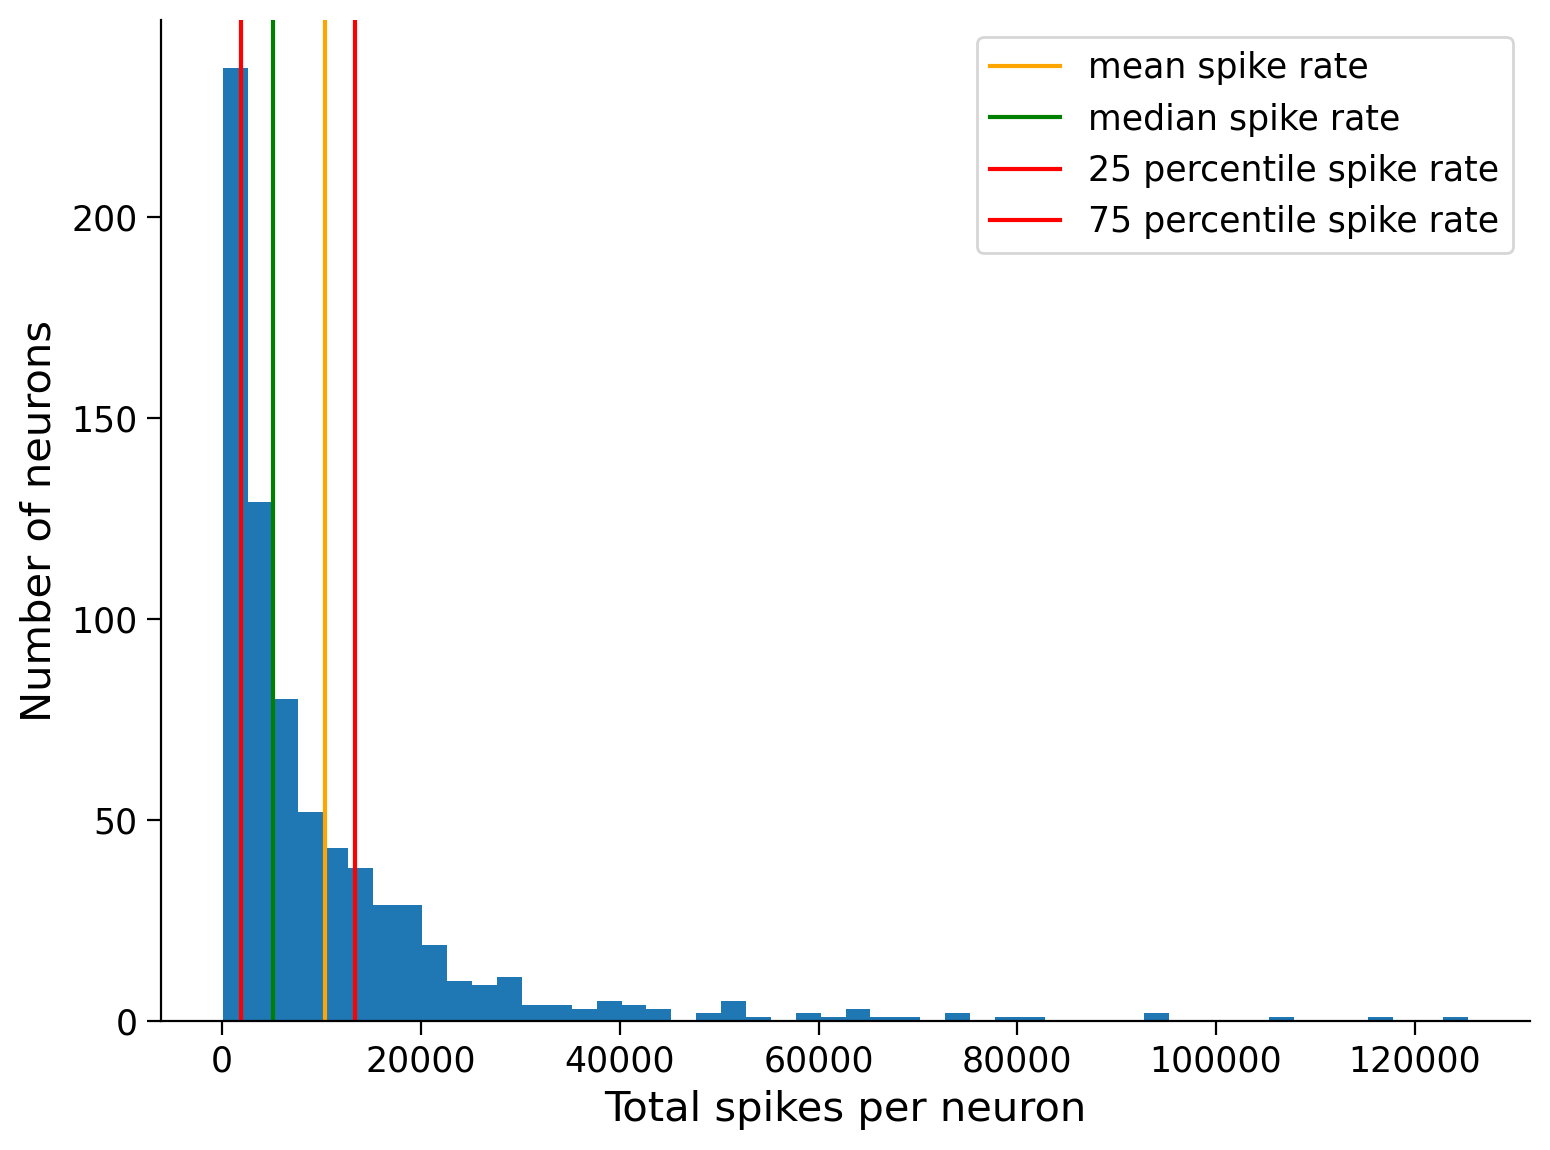

In [14]:
plt.hist(total_spikes_per_neuron, bins = 50, histtype='stepfilled')
plt.xlabel('Total spikes per neuron')
plt.ylabel('Number of neurons')
plt.axvline(mean_spike_count, color = 'orange', label = 'mean spike rate')
plt.axvline(median_spike_count, color = 'green', label = 'median spike rate')
plt.axvline(q1, color = 'red', label = '25 percentile spike rate')
plt.axvline(q3, color = 'red', label = '75 percentile spike rate')
plt.legend();

**Visualizing neuron spiking activities**

In [15]:
#helper function to restrict time range
def restrict_spike_times (spike_times, time_interval):
    start_time, end_time = time_interval
    restrict_spike_times = []

    for sub_array in spike_times:
        restricted_sub_array = (sub_array >= start_time) & (sub_array <= end_time)
        restrict_spike_times.append(sub_array[restricted_sub_array])

    return np.array(restrict_spike_times, object)




In [16]:
time_interval = (5, 15)  # units are seconds after start of recording
interval_spike_times = restrict_spike_times(spike_times, time_interval)
print(interval_spike_times)

[array([14.822467], dtype=float32)
 array([ 5.0386   ,  5.4224334,  5.435567 ,  5.4808664,  5.6014   ,
         5.6606336,  7.0313334,  7.2695665,  7.338967 ,  7.3663   ,
         7.9765   ,  9.149966 , 10.4380665, 10.441033 , 10.453267 ,
        10.486067 , 10.499467 , 10.580067 , 10.585267 , 10.7438   ,
        10.8243   , 11.100833 , 12.315066 , 13.0038   , 13.588667 ,
        13.895766 , 14.637867 , 14.8004   ], dtype=float32)
 array([], dtype=float32) array([], dtype=float32)
 array([ 9.272734, 14.822833], dtype=float32) array([], dtype=float32)
 array([13.743366, 13.8492  ], dtype=float32) array([], dtype=float32)
 array([], dtype=float32) array([12.324734], dtype=float32)
 array([], dtype=float32)
 array([ 5.9807  ,  8.2785  ,  8.650467,  9.3275  ,  9.8145  , 11.4934  ,
        12.740167], dtype=float32)
 array([ 6.3959665,  6.760733 ,  7.0457335,  9.170267 ,  9.1994   ,
        11.7377   ], dtype=float32)
 array([ 5.1873   ,  5.3052335,  5.497667 ,  5.5759335,  5.6735334,
     

In [17]:
original_counts = sum([len(spikes) for spikes in spike_times])
interval_counts = sum([len(spikes) for spikes in interval_spike_times])

frac_interval_spikes = interval_counts / original_counts
print(f'{frac_interval_spikes: .2%} of the total spikes in the interval')

 0.33% of the total spikes in the interval


**Finding out the proportion of time that this time interval represent in the total experiment time**

In [18]:
spike_times_flat = np.concatenate(spike_times)
experiment_duration = np.ptp(spike_times_flat)
interval_duration = time_interval[1] - time_interval[0]

frac_interval_time = interval_duration / experiment_duration
print(f"{frac_interval_time:.2%} of the total time is in the interval")

0.37% of the total time is in the interval


In [19]:
print(f'spike_times : {spike_times}', f'spike_times_flat : {spike_times_flat}')
print(f'length of spike time flattened: {len(spike_times_flat)}')
#Through observing the number of elements in spike_times and spike_times_flat: np.concatenate simply flattens the two dimensional array into an one dimensional array

spike_times : [array([8.1489998e-01, 1.4822467e+01, 2.4964600e+01, 2.5143600e+01,
        3.8870899e+01, 5.0820801e+01, 5.4806866e+01, 5.9511833e+01,
        8.0470367e+01, 1.2709637e+02, 1.6678714e+02, 1.7524760e+02,
        1.7728830e+02, 1.7831754e+02, 2.3178033e+02, 2.4066676e+02,
        2.7128897e+02, 3.0554150e+02, 3.0564987e+02, 3.1116019e+02,
        3.1275296e+02, 3.1846918e+02, 3.2280109e+02, 3.2485114e+02,
        3.5686102e+02, 3.5699719e+02, 3.7701962e+02, 3.8818140e+02,
        3.9037332e+02, 4.3421207e+02, 4.4229883e+02, 4.7392587e+02,
        4.8475021e+02, 5.0332483e+02, 5.0333578e+02, 5.0336313e+02,
        5.0341571e+02, 5.3048364e+02, 5.7414423e+02, 5.8498682e+02,
        5.8690369e+02, 5.9334210e+02, 6.1483112e+02, 6.5422388e+02,
        6.5453082e+02, 6.5481042e+02, 7.1913885e+02, 7.3967511e+02,
        7.4461981e+02, 7.4536530e+02, 7.5823090e+02, 7.5842230e+02,
        7.6530389e+02, 7.7090735e+02, 7.9484314e+02, 8.0276129e+02,
        8.0647791e+02, 8.0952216e+

**Plotting a single neuron spiking sequence using raster plot**

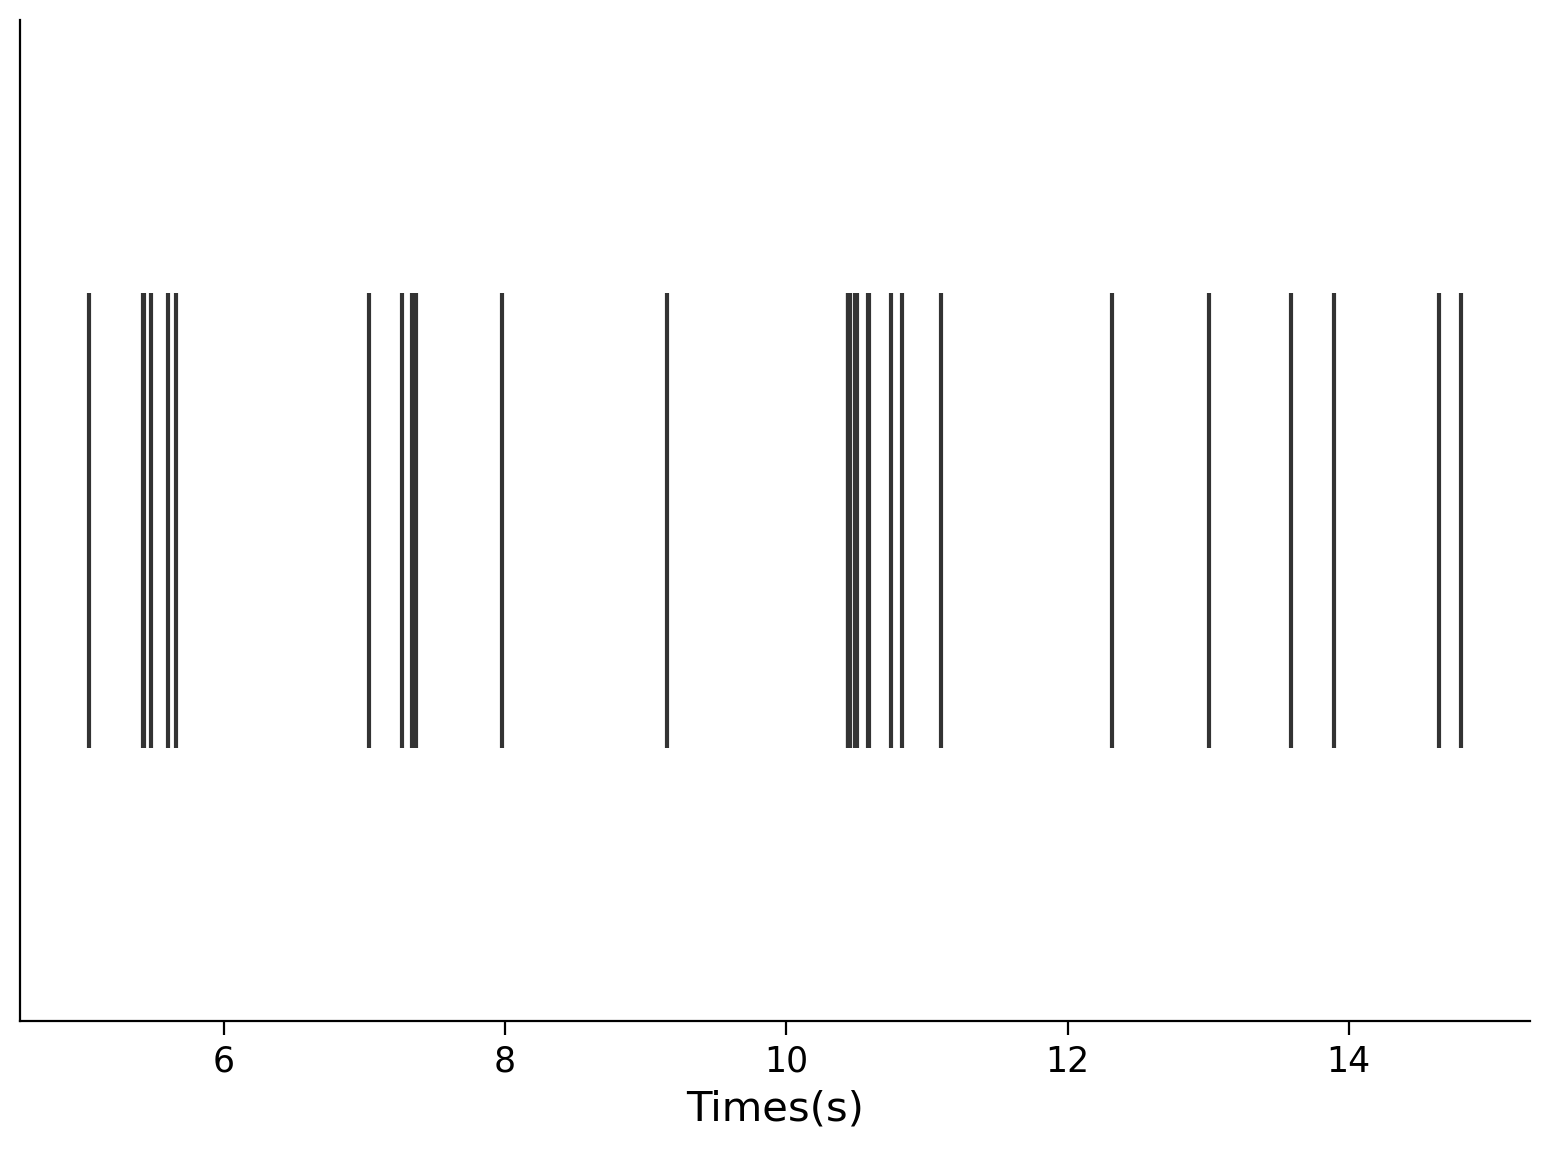

In [ ]:
neuron_idx = 1
plt.eventplot(interval_spike_times[neuron_idx], colors='.2')
plt.xlabel("Times(s)")
plt.yticks([]);



**Plotting for multiple neurons**

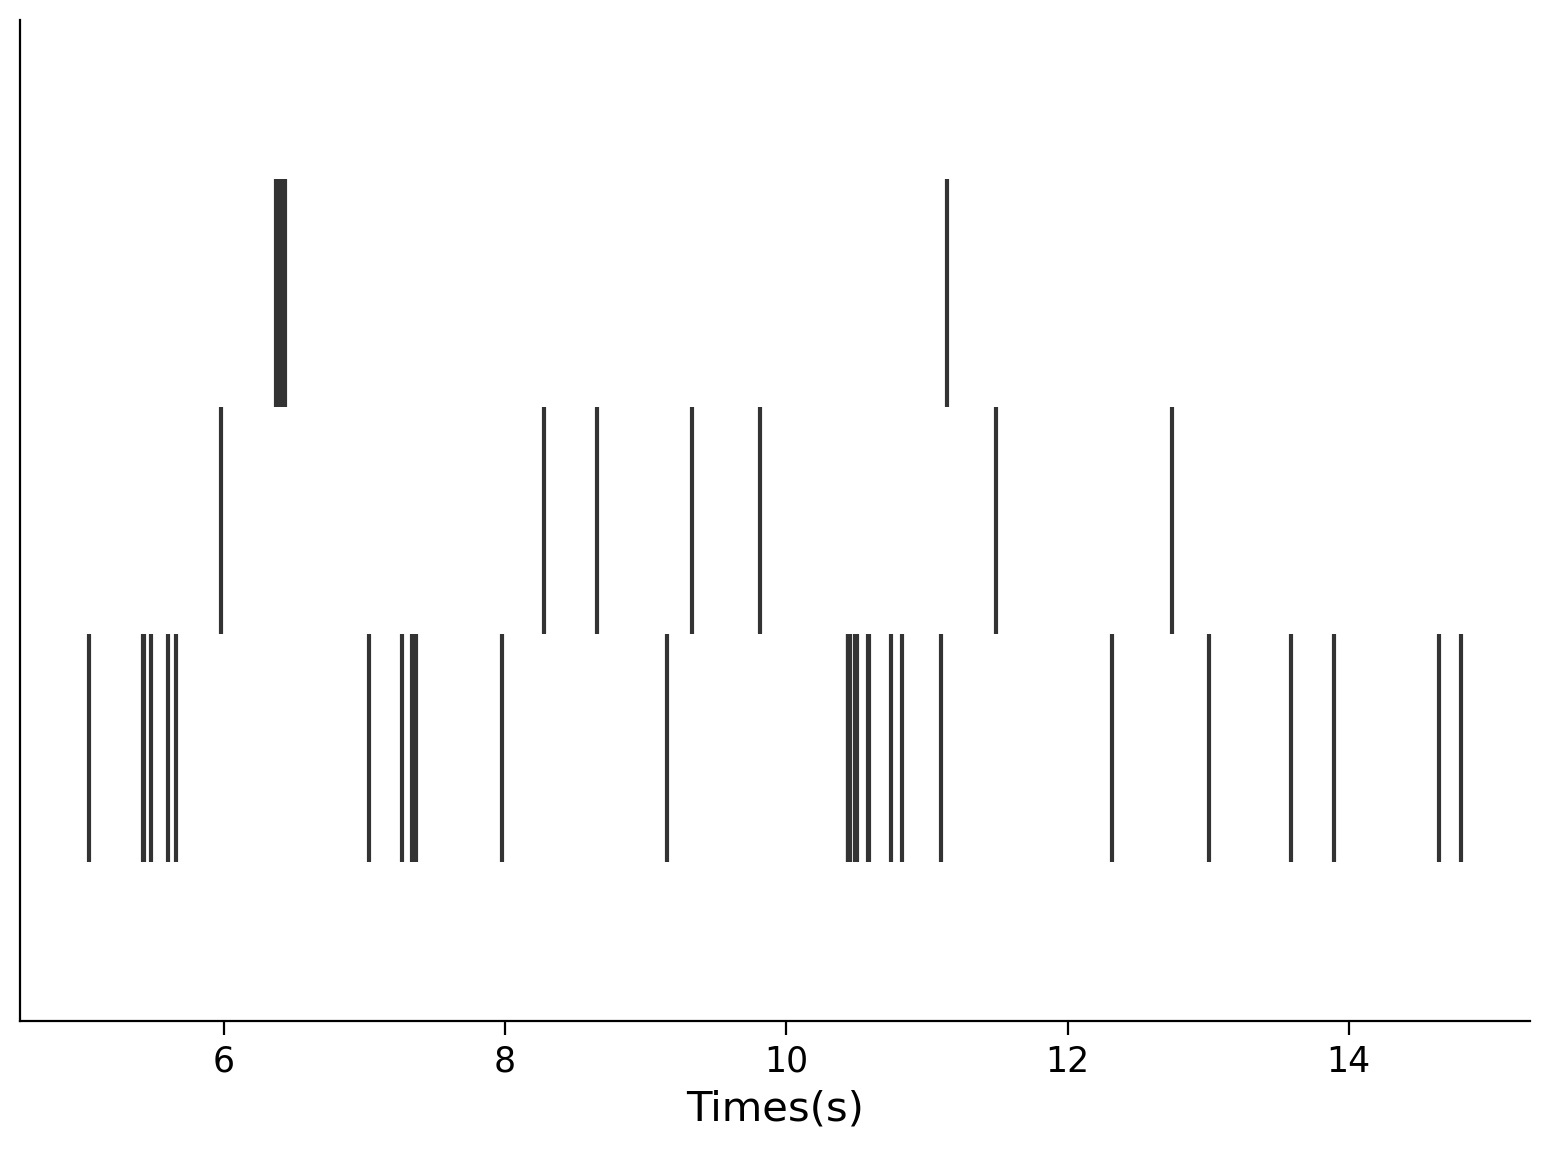

In [20]:
neuron_idx = [1, 11, 51]
plt.eventplot(interval_spike_times[neuron_idx], colors='.2')
plt.xlabel("Times(s)")
plt.yticks([]);

**Plotting the spiking activity of each 5th neuron in the array**

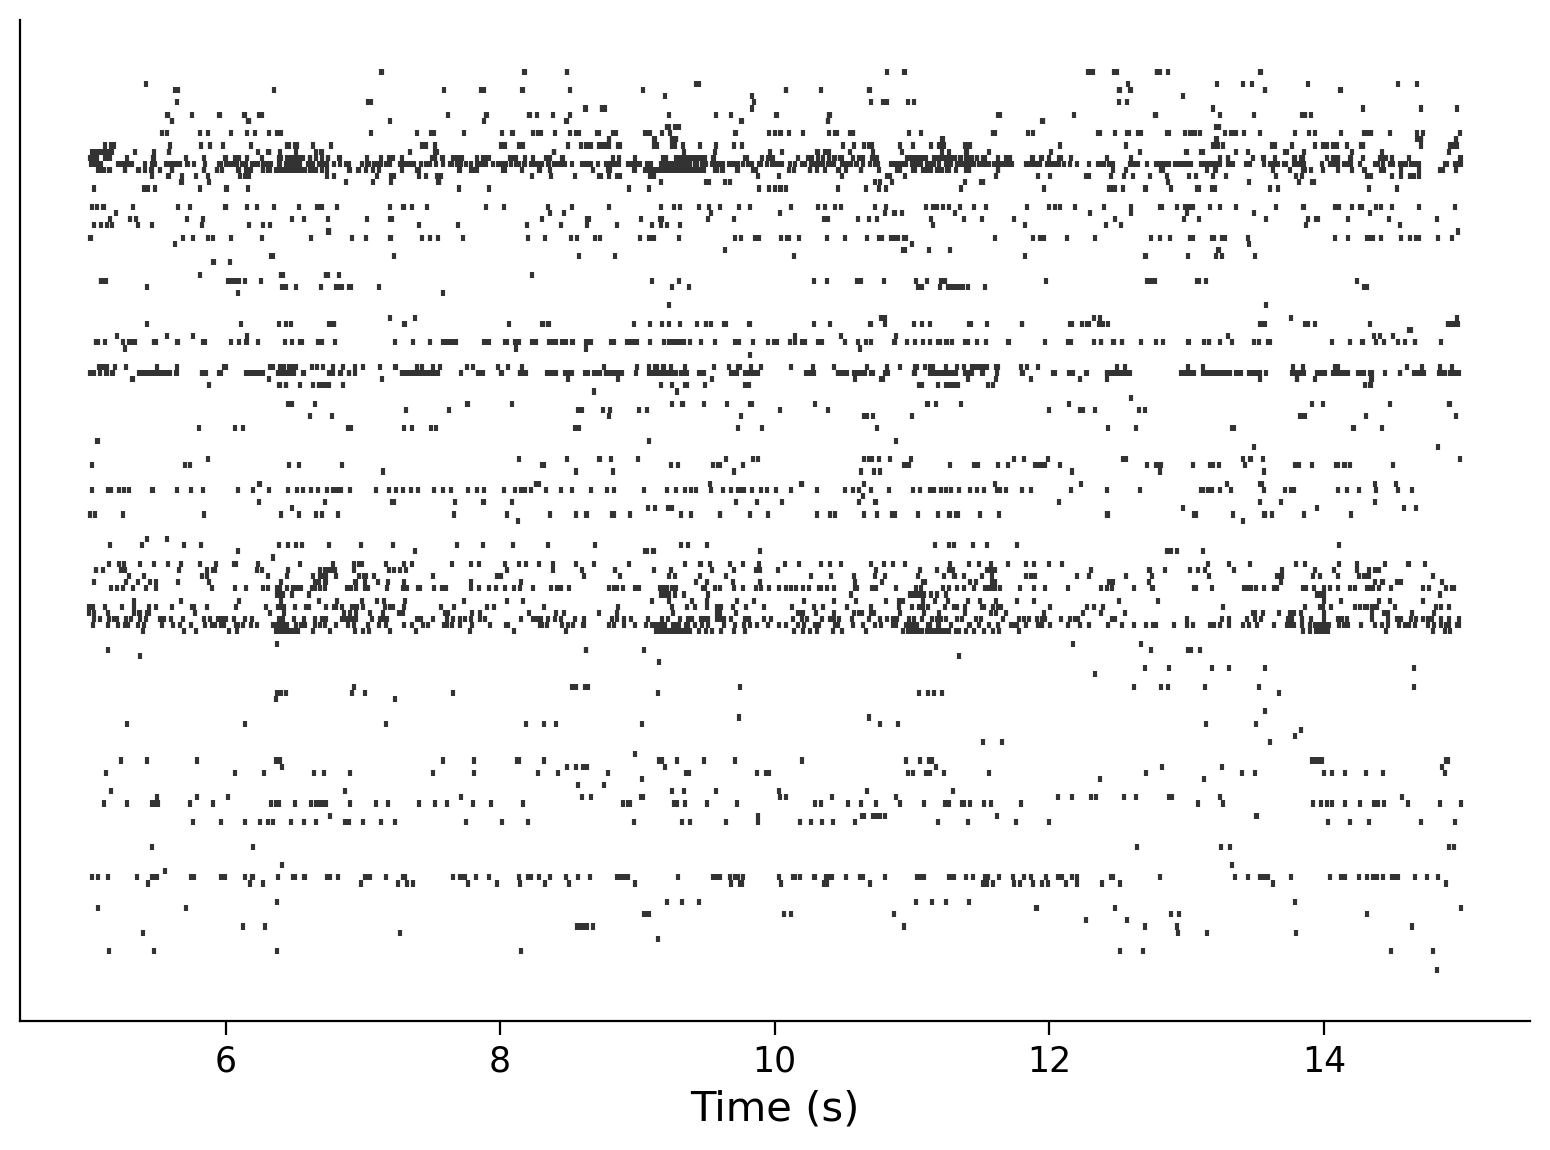

In [21]:
neuron_idx = np.arange(0, len(spike_times), 5)
plt.eventplot(interval_spike_times[neuron_idx], color=".2")
plt.xlabel("Time (s)")
plt.yticks([]);

**Determining the interspike interval of the set of neurons (ISI)**

Extract the spike times for one of the neurons/

Compute the ISIs (the amount of time between spikes, or equivalently, the difference between adjacent spike times)/

Plot a histogram with the array of individual ISIs

283 neuron spikes: [0.01036667 0.05183334 0.0124     ... 0.02490234 0.0144043  0.05834961]


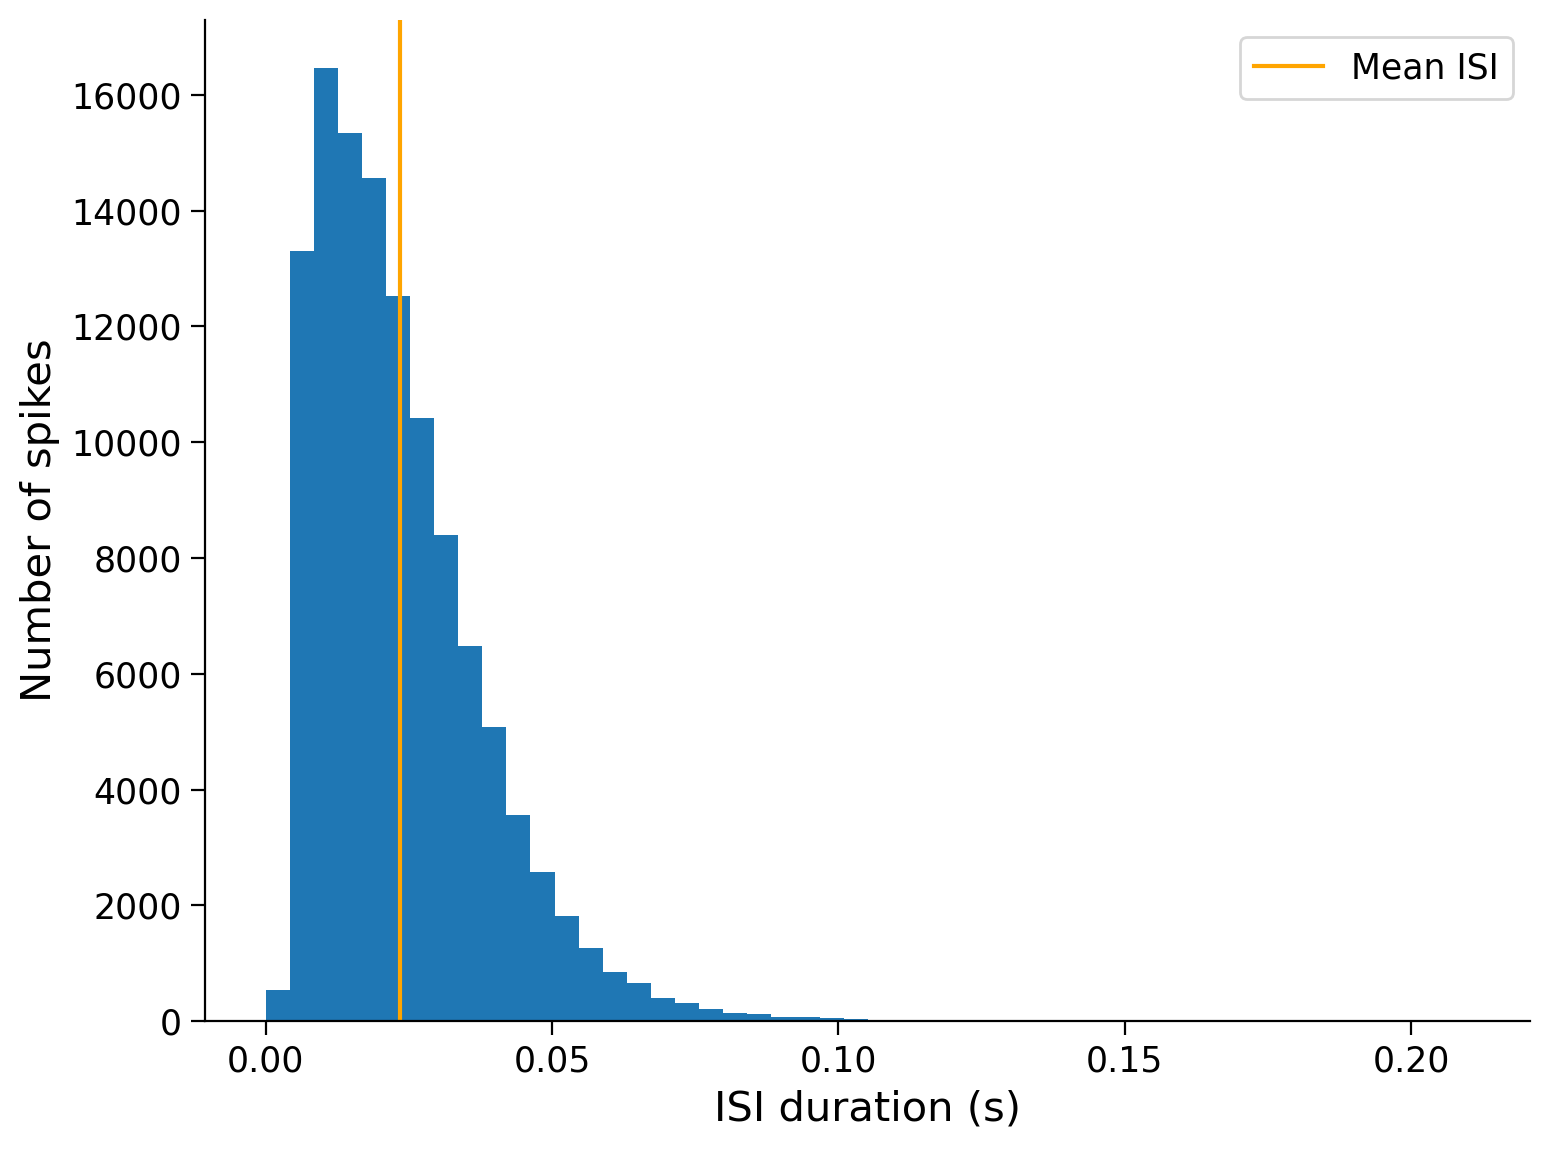

In [22]:
def compute_single_neuron_isis(spike_times, neuron_idx):
    singel_neuron_spikes = spike_times[neuron_idx]
    isis = np.diff(singel_neuron_spikes)

    return isis



#Computing isis
single_neuron_isis = compute_single_neuron_isis(spike_times, neuron_idx = 283)

print(f'283 neuron spikes: {single_neuron_isis}')

#Visualize isis
plot_isis(single_neuron_isis)


**Using exponential, inverse, and linear function to model the data**

In [23]:
def exponential(xs, scale, rate, x0):
    ys = scale * np.exp(rate * (xs - x0))
    return ys

def inverse(xs, scale, x0):
  ys = scale / (xs - x0)
  return ys

def linear(xs, slope, y0):

  ys = slope * xs + y0
  return ys



In [ ]:
#@markdown Be sure to run this cell to enable the demo
# Don't worry about understanding this code! It's to setup an interactive plot.
single_neuron_idx = 283
single_neuron_spikes = spike_times[single_neuron_idx]
single_neuron_isis = np.diff(single_neuron_spikes)

counts, edges = np.histogram(
  single_neuron_isis,
  bins=50,
  range=(0, single_neuron_isis.max())
)

functions = dict(
  exponential= exponential,
  inverse= inverse,
  linear= linear,
)

colors = dict(
  exponential="C1",
  inverse="C2",
  linear="C4",
)

@widgets.interact(
  exp_scale=widgets.FloatSlider(1000, min=0, max=20000, step=250),
  exp_rate=widgets.FloatSlider(-10, min=-200, max=50, step=1),
  exp_x0=widgets.FloatSlider(0.1, min=-0.5, max=0.5, step=0.005),
  inv_scale=widgets.FloatSlider(1000, min=0, max=3e2, step=10),
  inv_x0=widgets.FloatSlider(0, min=-0.2, max=0.2, step=0.01),
  lin_slope=widgets.FloatSlider(-1e5, min=-6e5, max=1e5, step=10000),
  lin_y0=widgets.FloatSlider(10000, min=0, max=4e4, step=1000),
)
def fit_plot(
  exp_scale=1000, exp_rate=-10, exp_x0=0.1,
  inv_scale=1000, inv_x0=0,
  lin_slope=-1e5, lin_y0=2000,
):
  """Helper function for plotting function fits with interactive sliders."""
  func_params = dict(
    exponential=(exp_scale, exp_rate, exp_x0),
    inverse=(inv_scale, inv_x0),
    linear=(lin_slope, lin_y0),
  )
  f, ax = plt.subplots()
  ax.fill_between(edges[:-1], counts, step="post", alpha=.5)
  xs = np.linspace(1e-10, edges.max())
  for name, function in functions.items():
    ys = function(xs, *func_params[name])
    ax.plot(xs, ys, lw=3, color=colors[name], label=name);
  ax.set(
      xlim=(edges.min(), edges.max()),
      ylim=(0, counts.max() * 1.1),
      xlabel="ISI (s)",
      ylabel="Number of spikes",
  )
  ax.legend()
  plt.show()